### Parte 1

Importar las bibliotecas que son usadas en el desarrollo del laboratorio

In [2]:
#Bibliotecas propias
%matplotlib inline
import os,os.path,math,scipy
import PIL

from datasets import ClassLabel

#Bibliotecas para LeNet
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

import seaborn as sns

import pandas as pd

import torchvision
from torch import nn
from d2l import torch as d2l

import tensorflow as tf


In [3]:
#Se setean las seeds
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Verifica que las carpetas de las clases tengan la cantidad de imagenes N

In [4]:
def same_amount_of_n_images(img_dir_list,N):
    for img_dir in img_dir_list:
        img_count = len([name for name in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, name))])
        if(img_count < N):
            return False
    return True

Se definen los cambios para las entradas

In [5]:
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize
    ])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize
    ])

In [6]:
def save (list_total,list_index,N):
    aux = np.random.choice(list_index, N, replace=False)
    list_total = np.append(list_total,aux)
    return list_total

In [7]:
def get_index_values(train_images,N):
    N = N
    aux = np.ndarray([0])
    index_list = np.ndarray([0])
    aux_label = 0
    largo = len(train_images)
    for i in range(largo):
        label_y = train_images[i][1]
        if label_y == aux_label:
            aux = np.append(aux,i)
        else:
            aux_label = label_y
            i= i-1
            index_list = save(index_list,aux,N)
            aux = np.ndarray([0])
    index_list = save(index_list,aux,N)
    return index_list
        

Lectura del conjunto de datos, deberá diseñar una estrategia para la selección y lectura del sub conjunto de datos, es decir, se debe crear un conjuntos de datos pequeño que contenga entre 3 a 5 clases y una cantidad de $N$ ejemplos para cada clase, con el fin de tener un conjunto de datos balanceado con un tamaño que se pueda trabajar con los recursos disponibles.


In [8]:
#Se define la cantidad N de ejemplos por clase
N = 30

#Numero de iteraciones para aumentar la cantidad de imagenes.
n_iteraciones = 5

AcuraIntegraTypeR2001_dir = 'data/train/AcuraIntegraTypeR2001'
AcuraRLSedan2012_dir = 'data/train/AcuraRLSedan2012'
AcuraTLSedan2012_dir = 'data/train/AcuraTLSedan2012'
AcuraTLType_S2008_dir = 'data/train/AcuraTLType_S2008'
AcuraTSXSedan2012_dir = 'data/train/AcuraTSXSedan2012'

aux_dir_list = [AcuraIntegraTypeR2001_dir,AcuraRLSedan2012_dir,AcuraTLSedan2012_dir,AcuraTLType_S2008_dir,AcuraTSXSedan2012_dir]

if same_amount_of_n_images(aux_dir_list,N):
    train_images = []
    test_images = []
    
    # Se aplican técnicas para aumentar la cantidad de imágenes en los datos de entrenamiento, 
    for i in range(n_iteraciones):
        train_aux = torchvision.datasets.ImageFolder('data/train',train_augs)
        train_images = torch.utils.data.ConcatDataset([train_images,train_aux])
        test_aux = torchvision.datasets.ImageFolder('data/test',test_augs)
        test_images = torch.utils.data.ConcatDataset([test_images,test_aux])    
    #Se obtienen los indicies para las N imagenes de cada clase.
    train_index = get_index_values(train_images,N)
    #Se filtra train_images, dejando unicamente las imagenes con indices presentes en train_index
    train_images = torch.utils.data.Subset(train_images, train_index.astype(int))
    
    #Se ajustan los datos de Test, par que siguan la forma: Train (70%) y Test (30%).
    test_size = int(0.3 * len(train_images))
    test_data = torch.utils.data.Subset(test_images, np.random.choice(len(test_images), test_size, replace=False))
    
else:
    print('N invalido')

In [9]:
valid_size = int(0.1 * len(train_images))
train_size = len(train_images) - valid_size

# Se separa el dataset y se guarda uno de entrenamiento y otro de validación
train_data, valid_data = torch.utils.data.random_split(train_images, [train_size, valid_size])

In [10]:
len(train_images)

750

In [11]:
len(test_data)

225

In [12]:
len(valid_data)

75

In [13]:
#Se crean los dataloaders para procesar los datos a travez de las iteraciones.
#Se trabaja con un tamaño de lote BATCH_SIZE
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data,
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

### Parte 2

Creación de una arquitectura desde cero, para esté paso se recomienda adaptar la implementación LeNet vista en clases. Cuya implementación debe funcionar tanto en CPU como en GPU.

Red con configuracion 1.

In [14]:
class LeNet_v1(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, 
                               out_channels = 16, 
                               kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 16, 
                               out_channels = 32, 
                               kernel_size = 3)
        self.conv3 = nn.Conv2d(in_channels = 32, 
                               out_channels = 64, 
                               kernel_size = 3)
        self.conv4 = nn.Conv2d(in_channels = 64, 
                               out_channels = 128, 
                               kernel_size = 3)        
        self.fc_1 = nn.Linear(18432, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)
        self.dropout = nn.Dropout(0.5)
        self.flatten1 = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
    
        #x = x.view(x.shape[0], -1)
        x = self.flatten1(x)
        h = x
        
        x = self.dropout(x) 
        
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)
    
        return x, h

Red con configuracion 2.

In [15]:
class LeNet_v2(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, 
                               out_channels = 16, 
                               kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 16, 
                               out_channels = 32, 
                               kernel_size = 3)    
        self.fc_1 = nn.Linear(93312, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)
        self.dropout = nn.Dropout(0.5)
        self.flatten1 = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
    
        #x = x.view(x.shape[0], -1)
        x = self.flatten1(x)
        h = x
        
        x = self.dropout(x) 
        
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)
    
        return x, h

Red con configuracion 3.

In [16]:
class LeNet_v3(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, 
                               out_channels = 16, 
                               kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 16, 
                               out_channels = 32, 
                               kernel_size = 3)
        self.conv3 = nn.Conv2d(in_channels = 32, 
                               out_channels = 64, 
                               kernel_size = 3)
        self.conv4 = nn.Conv2d(in_channels = 64, 
                               out_channels = 128, 
                               kernel_size = 3)        
        self.fc_1 = nn.Linear(18432, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)
        self.dropout = nn.Dropout(0.5)
        self.flatten1 = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
    
        #x = x.view(x.shape[0], -1)
        x = self.flatten1(x)
        h = x
        
        x = self.dropout(x) 
        x = self.fc_1(x)
        x = F.tanh(x)
        x = self.fc_2(x)
        x = F.tanh(x)
        x = self.fc_3(x)
    
        return x, h

In [17]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [18]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in iterator:   
        x = x.to(device)
        y = torch.tensor(y).to(device)
        optimizer.zero_grad() 
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = torch.tensor(y).to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
def get_predictions(model, iterator, device):
    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    return images, labels, probs

In [22]:
def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

In [23]:
def red_cnn(model,epocas):
    model = model
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = criterion.to(device)

    EPOCHS = epocas
    epoch_loss = []
    epoch_acc = []

    best_valid_loss = float('inf')
    for epoch in range(EPOCHS):
        start_time = time.monotonic()
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut2-model.pt')

        end_time = time.monotonic()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        epoch_loss.append([train_loss,valid_loss,test_loss])
        epoch_acc.append([train_acc*100,valid_acc*100,test_acc*100])
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
    # Crear los gráficos de entrenamiento, donde se vea el error en los conjuntos de train y 
    # test durante cada época de entrenamiento
    df1 = pd.DataFrame(epoch_loss, columns=['Train loss', 'Val loss','Test loss'])
    df2 = pd.DataFrame(epoch_acc, columns=['Train Acc', 'Val Acc','Test Acc'])
    df1.plot.line()
    plt.grid(True)

    df2.plot.line()
    plt.grid(True)

    model.load_state_dict(torch.load('tut2-model.pt'))
    # Crear los gráficos de entrenamiento, donde se vea el error en los conjuntos de train y
    # test durante cada época de entrenamiento
    images, labels, probs = get_predictions(model, test_iterator, device)
    pred_labels = torch.argmax(probs, 1)

    plot_confusion_matrix(labels, pred_labels)    

In [44]:
OUTPUT_DIM = 5
lenet1 = LeNet_v1(OUTPUT_DIM)
lenet2 = LeNet_v2(OUTPUT_DIM)
lenet3 = LeNet_v2(OUTPUT_DIM)

/Users/matiascoronado/opt/anaconda3/envs/python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/Users/matiascoronado/opt/anaconda3/envs/python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch: 01 | Epoch Time: 2m 37s
	Train Loss: 1.452 | Train Acc: 31.55%
	 Val. Loss: 1.408 |  Val. Acc: 29.30%
	Test Loss: 1.459 | Test Acc: 33.48%
Epoch: 02 | Epoch Time: 1m 49s
	Train Loss: 1.365 | Train Acc: 35.99%
	 Val. Loss: 1.369 |  Val. Acc: 41.02%
	Test Loss: 1.503 | Test Acc: 34.90%
Epoch: 03 | Epoch Time: 1m 37s
	Train Loss: 1.317 | Train Acc: 38.66%
	 Val. Loss: 1.429 |  Val. Acc: 35.94%
	Test Loss: 1.468 | Test Acc: 37.88%
Epoch: 04 | Epoch Time: 1m 37s
	Train Loss: 1.292 | Train Acc: 43.64%
	 Val. Loss: 1.548 |  Val. Acc: 33.98%
	Test Loss: 1.557 | Test Acc: 31.77%
Epoch: 05 | Epoch Time: 1m 37s
	Train Loss: 1.253 | Train Acc: 46.16%
	 Val. Loss: 1.272 |  Val. Acc: 48.05%
	Test Loss: 1.537 | Test Acc: 38.02%
Epoch: 06 | Epoch Time: 1m 37s
	Train Loss: 1.179 | Train Acc: 49.14%
	 Val. Loss: 1.355 |  Val. Acc: 40.62%
	Test Loss: 1.544 | Test Acc: 34.90%
Epoch: 07 | Epoch Time: 1m 37s
	Train Loss: 1.110 | Train Acc: 54.26%
	 Val. Loss: 1.206 |  Val. Acc: 54.30%
	Test Loss: 1.5

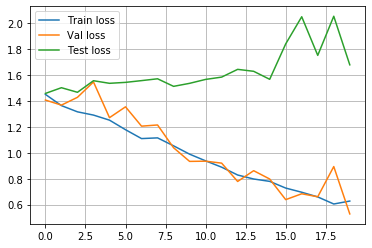

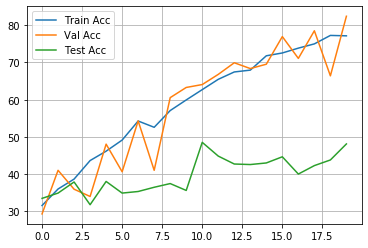

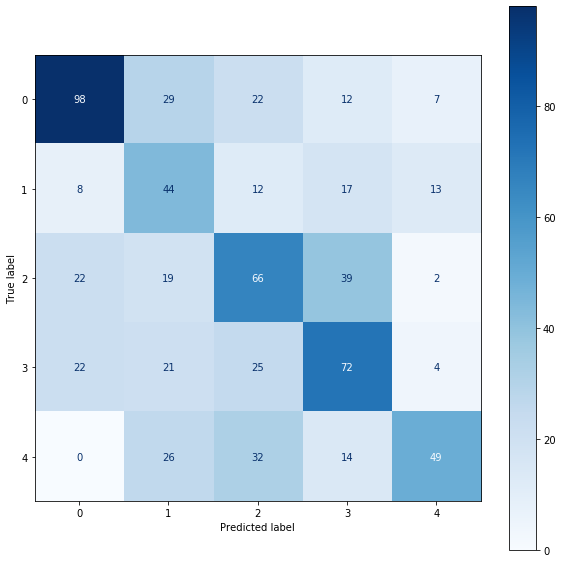

In [37]:
red_cnn(lenet1,20)

In [ ]:
red_cnn(lenet2,20)

In [ ]:
red_cnn(lenet3,20)

### Parte 3

In [45]:
# Ejemplo dogs breeds (Para saber que arquitectura usar y como modificarla)
# https://www.tensorflow.org/tutorials/images/transfer_learning

Importar una arquitectura profunda que se encuentra pre-entrenada con ImageNet

In [24]:
pretrained_net =  torchvision.models.resnet18(pretrained=True)

Realizar la modificación en la arquitectura para poder clasificar el número de clases que usted haya escogido.

In [25]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 5)
nn.init.xavier_uniform_(finetune_net.fc.weight);

Aplicar Fine-tuning en la arquitectura profunda, para re-entrenar con el conjunto de datos seleccionado manteniendo los pesos de las arquitecturas ResNet, VGG o DenseNet. Cuya implementación creada debe funcionar tanto en CPU como en GPU.

In [26]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with mutiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    best_loss = float('inf')
    """Train a model with mutiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if l < best_loss:
                best_loss = l
                torch.save(net.state_dict(), 'tut2-model.pt') 
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [27]:
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(net, learning_rate, batch_size=BATCH_SIZE, num_epochs=2,
                      param_group=True):
    train_iter = train_iterator
    test_iter = test_iterator
    
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

loss 0.955, train acc 0.644, test acc 0.582
3.0 examples/sec on [device(type='cpu')]


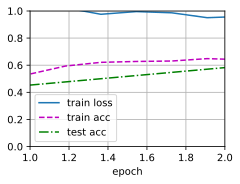

In [104]:
net = train_fine_tuning(finetune_net, 5e-5)

In [29]:
finetune_net = torchvision.models.resnet18(pretrained=False)

finetune_net.load_state_dict(torch.load('tut2-model.pt'))
# Crear los gráficos de entrenamiento, donde se vea el error en los conjuntos de train y
# test durante cada época de entrenamiento
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)

plot_confusion_matrix(labels, pred_labels)  

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "module.conv1.weight", "module.bn1.weight", "module.bn1.bias", "module.bn1.running_mean", "module.bn1.running_var", "module.bn1.num_batches_tracked", "module.layer1.0.conv1.weight", "module.layer1.0.bn1.weight", "module.layer1.0.bn1.bias", "module.layer1.0.bn1.running_mean", "module.layer1.0.bn1.running_var", "module.layer1.0.bn1.num_batches_tracked", "module.layer1.0.conv2.weight", "module.layer1.0.bn2.weight", "module.layer1.0.bn2.bias", "module.layer1.0.bn2.running_mean", "module.layer1.0.bn2.running_var", "module.layer1.0.bn2.num_batches_tracked", "module.layer1.1.conv1.weight", "module.layer1.1.bn1.weight", "module.layer1.1.bn1.bias", "module.layer1.1.bn1.running_mean", "module.layer1.1.bn1.running_var", "module.layer1.1.bn1.num_batches_tracked", "module.layer1.1.conv2.weight", "module.layer1.1.bn2.weight", "module.layer1.1.bn2.bias", "module.layer1.1.bn2.running_mean", "module.layer1.1.bn2.running_var", "module.layer1.1.bn2.num_batches_tracked", "module.layer2.0.conv1.weight", "module.layer2.0.bn1.weight", "module.layer2.0.bn1.bias", "module.layer2.0.bn1.running_mean", "module.layer2.0.bn1.running_var", "module.layer2.0.bn1.num_batches_tracked", "module.layer2.0.conv2.weight", "module.layer2.0.bn2.weight", "module.layer2.0.bn2.bias", "module.layer2.0.bn2.running_mean", "module.layer2.0.bn2.running_var", "module.layer2.0.bn2.num_batches_tracked", "module.layer2.0.downsample.0.weight", "module.layer2.0.downsample.1.weight", "module.layer2.0.downsample.1.bias", "module.layer2.0.downsample.1.running_mean", "module.layer2.0.downsample.1.running_var", "module.layer2.0.downsample.1.num_batches_tracked", "module.layer2.1.conv1.weight", "module.layer2.1.bn1.weight", "module.layer2.1.bn1.bias", "module.layer2.1.bn1.running_mean", "module.layer2.1.bn1.running_var", "module.layer2.1.bn1.num_batches_tracked", "module.layer2.1.conv2.weight", "module.layer2.1.bn2.weight", "module.layer2.1.bn2.bias", "module.layer2.1.bn2.running_mean", "module.layer2.1.bn2.running_var", "module.layer2.1.bn2.num_batches_tracked", "module.layer3.0.conv1.weight", "module.layer3.0.bn1.weight", "module.layer3.0.bn1.bias", "module.layer3.0.bn1.running_mean", "module.layer3.0.bn1.running_var", "module.layer3.0.bn1.num_batches_tracked", "module.layer3.0.conv2.weight", "module.layer3.0.bn2.weight", "module.layer3.0.bn2.bias", "module.layer3.0.bn2.running_mean", "module.layer3.0.bn2.running_var", "module.layer3.0.bn2.num_batches_tracked", "module.layer3.0.downsample.0.weight", "module.layer3.0.downsample.1.weight", "module.layer3.0.downsample.1.bias", "module.layer3.0.downsample.1.running_mean", "module.layer3.0.downsample.1.running_var", "module.layer3.0.downsample.1.num_batches_tracked", "module.layer3.1.conv1.weight", "module.layer3.1.bn1.weight", "module.layer3.1.bn1.bias", "module.layer3.1.bn1.running_mean", "module.layer3.1.bn1.running_var", "module.layer3.1.bn1.num_batches_tracked", "module.layer3.1.conv2.weight", "module.layer3.1.bn2.weight", "module.layer3.1.bn2.bias", "module.layer3.1.bn2.running_mean", "module.layer3.1.bn2.running_var", "module.layer3.1.bn2.num_batches_tracked", "module.layer4.0.conv1.weight", "module.layer4.0.bn1.weight", "module.layer4.0.bn1.bias", "module.layer4.0.bn1.running_mean", "module.layer4.0.bn1.running_var", "module.layer4.0.bn1.num_batches_tracked", "module.layer4.0.conv2.weight", "module.layer4.0.bn2.weight", "module.layer4.0.bn2.bias", "module.layer4.0.bn2.running_mean", "module.layer4.0.bn2.running_var", "module.layer4.0.bn2.num_batches_tracked", "module.layer4.0.downsample.0.weight", "module.layer4.0.downsample.1.weight", "module.layer4.0.downsample.1.bias", "module.layer4.0.downsample.1.running_mean", "module.layer4.0.downsample.1.running_var", "module.layer4.0.downsample.1.num_batches_tracked", "module.layer4.1.conv1.weight", "module.layer4.1.bn1.weight", "module.layer4.1.bn1.bias", "module.layer4.1.bn1.running_mean", "module.layer4.1.bn1.running_var", "module.layer4.1.bn1.num_batches_tracked", "module.layer4.1.conv2.weight", "module.layer4.1.bn2.weight", "module.layer4.1.bn2.bias", "module.layer4.1.bn2.running_mean", "module.layer4.1.bn2.running_var", "module.layer4.1.bn2.num_batches_tracked", "module.fc.weight", "module.fc.bias". 

In [114]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  